# Space Invaders - Double-Q-learning Training

Authors: Nicolás Arrieta Larraza

Date: 14/05/2021

---

This notebook describes the learning algorithm and its implementation. The result analysis will be done in the *Space Invaders - Result Analysis* notebook.

## The Environment - Space Invaders Game

Space Invaders is an Atari game where the player controls a space ship with the goal of defeating an alien invation. The player has to shoot to destroy the aliens and dodge from the aliens shots to stay alive.

We have chosen to work with the RAM observation. In this case, the observation of the environment is given by the state of the RAM, i.e., an array with 128 values. Each value is a byte (integer from 0-255). The RAM is a compact representation of the state in comparison to algorithms the display image as the state.

In this environment, the player can perform 6 actions: NOOP, RIGHT, LEFT, FIRE, RIGHTFIRE, and LEFTFIRE. Notice that, by default, each action is repeatedly performed for a duration of k frames, where k is uniformly sampled from {2,3,4}. In this case, the agent skips some frames in which it is not able to perform any other action, therefore, k is called the *frameskip*.

The reward in the Space Invaders gym environment is the score at the given time step. We have observed that different invasors (aliens) have different scores. For example, aliens from the first line have score 5 while aliens from the second line have score 10. When no alien is destroied, the reward is zero. There is no negative reward for losing lives, but the information of the number of lives can be read from gym the environment. 

## The Learning Algorithm

Because Space Invaders is a complex game with 6 actions and a big number of states, we have chosen to use a valua approximation algorithm: Double-Q-Learning. Here, we give a brief explanatoin of the Double-Q-Learning algorithm and its precedents: Q-Learning and Deep-Q-Learning.

### Q-Learning

Q-learning is an off-policy temporal difference algorithm. Q-learning estimates the action-value at a time $t$ for an action $a_t$ in a given state $s_t$ based on the difference between the expected action-value $Q(s_t, a_t)$, and the current action-value, $r_{t+1} + \gamma Q(s_{t+1}, a_t)$, where $\gamma$ is a discount factor for future rewards and $r_{t+1}$ is the reward at the time $t$. The q-value update can be written as:

$Q(s_t, a_t) \leftarrow (1 - \alpha)Q(s_t, a_t) + \alpha[r_{t+1} + \gamma Q(s_{t+1}, a_t)]$

With the introduction of the learning rate $\alpha$. Using the next action as the optimal action, i.e., the one that maximizes the value, we have:

$Q(s_t, a_t) \leftarrow (1 - \alpha)Q(s_t, a_t) + \alpha[r_{t+1} + \gamma  \underset{a}{\max}(Q(s_{t+1}, a_t))]$

Or

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha[r_{t+1} + \gamma  \underset{a}{\max}(Q(s_{t+1}, a_t)) - Q(s_t, a_t)]$

### Deep-Q-Learning

The Q-learning algorithm is not suitable for high-dimensional state or action space, because the current action-value estimations have to be stores for each state-action pair. For that purpose, Deep-Q-learning was created. Deep-Q-Learning is a value approximation method, in which a Deep Neural Network (DNN) is used to estimate the Q-values for a given state. For a problem with a $n$ dimensional state and an $m$ actions, the DNN will learn a mapping from $\mathbb{R}^n$ to $\mathbb{R}^m$. 

The objective is to now learn the weights $\theta_i$ Q-network, and can be written as:

$\theta_{i+1} \leftarrow \theta_i + \alpha [r + \gamma \underset{a'}{\max} Q(s', a', \theta_{i}) - Q(s, a, \theta_i)]\nabla_{\theta_i} Q(s, a, \theta_i) $

Where $s', a'$ are the next state and action, respectivelly.

### Double-Q-Learning

In recent works, it was shown that using the same network to choose the best action and to evaluate the q-values leads to overestimation of the q-values. The Double Q learning algorithm gets around this by keeping
two DPP models. For each update, one set of weights is used to determine the greedy policy and the other to determine its value. Here, we will refer to the DNN used to determine the greedy policy as (main) model/network and the other one as target model/network. At every number of steps, the weights of the main model are coppied to the target model.

## The Learning Process

Besides the choice of algorithm parameters, a few implementation decisions had to be made. Here we describe our decisions regarding some aspects of the code. For the implementation of this algorithm, we have taken inspiration from three tutorials:

- [Training Deep Q Learning and Deep Q Networks (DQN) Intro and Agent from sentdex](https://pythonprogramming.net/training-deep-q-learning-dqn-reinforcement-learning-python-tutorial/)
- [Deep Q-Learning Tutorial: minDQN from Maik Wang](https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc)
- [Deep Reinforcement Learning to play Space Invaders from Nihit Desai and Abhimanyu Banerjee](https://nihit.github.io/resources/spaceinvaders.pdf)

### Epsilon-greedy exploration policy
We have used the $\epsilon$-greedy exploration policy to balance between exploration and exploitation.

### Epsilon decay function
At first we implemented a version in which the epsilon decayed exponentially with respect to a decay factor, however we observed that a linear function showed a better performance.

### Reward variation

We have tried to bound the rewards with values of the set {-1,0,1} where:
* -1 was given in case of life loss
*  1 was given in case of alien kill
*  0 otherwise

This approach was supposed to speed up the neural network training. Nevertheless, it resulted on a bad performance since the player did not move or shoot. 

We reached the conclusion that we should not bound the rewards since not all aliens give the same reward and that the model should learn that killing the aliens of the last row it is more worth in the long term.

### Terminal state
For a not terminal state, the estimated Q-value is the current reward summed with the discounted future reward. But for a terminal state, the expected Q-value is just the current reward, cause no future reward can be obtained. The step in which the game ends is a terminal reward. We have also included the step in which a life is lost as a terminal reward. We notice that this change helps the agent learn to avoid losing lives.

### Normalizing input
The input of the neural network consists of arrays of 128 bytes (RAM values) each of them expressed in a number between 0 and 255. We observed that normalizing the input by dividing it by 255 showed a better performance.

### Target Model weights' update frequency
We tried different configurations for the frequency in which the target model weights are updated including 100, 1000 and 10000 steps. The latter one has yield the best results.

### Network Architecture
We have implemented the same network as described in the [Deep Reinforcement Learning to play Space Invaders](https://nihit.github.io/resources/spaceinvaders.pdf) paper. It is a fully connnected network with 2 hidden layers. More details and explanations can be found in the code.

## Initial Settings

### Import Libraries

In [3]:
!apt update && apt install xvfb
!pip install gym-notebook-wrapper
!apt update && apt install python-opengl ffmpeg

import numpy as np
import os
import sys
import random
import pickle

import gym
import gnwrapper

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import Huber
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

### Set Path

We define the path for the outputs:

In [4]:
path = '/content/drive/My Drive/Lectures/Elm/'
version_name = "fv_test"

## Deep Q-Learning Agent

We define an agent to implement the Double-Q-learning Algorithm.

In [5]:
class DeepQLearningAgent():
  def __init__(self, env):
    """
      Initializes the class and sets the environment
    """
    self.env = env

  def get_approximator(self, gd_learning_rate):
    """
      Returns an ANN that is used to approximate the value function.
      Input: feature vector representing a state
      Output: vector representing the value of each action at the input state
    """

    # Gets the number of actions and the shape of each state
    state_shape = env.observation_space.shape
    number_of_actions = env.action_space.n

    # He Uniform initializes the weights with a zero-mean gaussian distribution,
    # where the variance is scaled by the number of input neurons in the layer
    # It is indicated to be used with relu activation
    init = HeUniform()

    # We use Relu activation to avoid vanishing gradients
    # We use two dense layers to extract the features of the RAM input array
    # We use a linear output layer to estimate the Q action-value
    model = Sequential([
        Dense(512, input_shape=state_shape, activation='relu', kernel_initializer=init),
        Dense(128, activation='relu', kernel_initializer=init),
        Dense(number_of_actions, activation='linear', kernel_initializer=init)
    ])

    # We use Huber loss because it is less sensitive to outliers than squared error
    # We use Adam optimizer to optimizer and accuracy as the metric
    model.compile(loss=Huber(), optimizer=Adam(lr=gd_learning_rate), metrics='accuracy')
    return model

  def show_approximator(self):
    """
      Shows the summary of the DNN approximator
    """
    if not self.model is None:
      self.model.summary()
    else:
      print("No model was set!")

  def preprocess_state(self, state, reshape=False):
    """
      Returns the normalized state (MinMax scaler) in the format required by the DNN
    """
    state = state/255

    # Reshape is used to add an array around the state
    # when predicting the action-value for a single state
    if reshape:
      state = state.reshape(1, -1)
    return state

  def train_approximator(self, replay_memory, gamma, mini_batch_size, min_replay_size, life_lost):
    """
      Trains the main model with a mini_batch of the replay memory and the defined parameters
    """

    # Only train the approximator if there's a minimum number of samples on the 
    # replay memory to guarantee time independence of samples
    if len(replay_memory) < min_replay_size:
      return

    # Randomly sample a number of time steps from the memory
    mini_batch = random.sample(replay_memory, mini_batch_size)
    # Get the state before the action and predict the action-value Q(s, a)
    states_t = np.array([self.preprocess_state(observation) for (observation, action, reward, new_observation, done) in mini_batch])
    q_list_t = self.model.predict(states_t)
    # Get the state after the action and predict the action-value Q(s', a') for the next state
    states_t_plus_one = np.array([self.preprocess_state(new_observation) for (observation, action, reward, new_observation, done) in mini_batch])
    q_list_t_plus_one = self.target_model.predict(states_t_plus_one)

    X = []
    y = []

    # Update the action-value of the actions taken
    for i, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done and not life_lost:     # Not a terminal state
          # New action-value is the step's reward plus the discounted future reward
          max_return = reward + gamma * np.max(q_list_t_plus_one[i][0])
        else:                              # Terminal state
          # New action-value is is the step's reward
          max_return = reward

        # Update the action-value of the taken action
        current_qs = q_list_t[i]
        current_qs[action] = max_return

        # Add to dataset
        X.append(self.preprocess_state(observation)) 
        y.append(current_qs)

    # Trains model on created dataset
    X = np.array(X)
    y = np.array(y)
    self.model.fit(X, y, verbose=0, shuffle=True)

  def train(self, 
            n_episodes,           # number of episodes to train
            max_epsilon,          # maximum exploration rate
            min_epsilon,          # minimum exploration rate
            gamma,                # discount rate
            gd_learning_rate,     # learning rate for the gradient descent
            mini_batch_size,      # number of samples taken from the replay memory for training
            min_replay_size):     # minimum replay size to train (does not train before gathering this amount of observations)         

    # Initialize model and target model
    self.model = self.get_approximator(gd_learning_rate)
    self.target_model = self.get_approximator(gd_learning_rate)
    # Set the weights of the target model as the main model
    self.target_model.set_weights(self.model.get_weights())

    TARGET_UPDATE_FREQ = 10000
    TRAIN_FREQ = 4

    # Initialize stats and counters
    reward_per_ep = [] # Total score per episode 
    steps_to_update_weights = 0  # Steps since last target update
    action_distribution = ( # Counts how many times each actions were chosen per episode (by exploitation)
        np.array([np.zeros(n_episodes), np.zeros(n_episodes), np.zeros(n_episodes),
        np.zeros(n_episodes), np.zeros(n_episodes), np.zeros(n_episodes)]))
    
    # Initialize replay memory
    replay_memory = []

    # Define initial epsilon and epsilon decay linearly
    epsilon = max_epsilon
    epsilon_decay = (max_epsilon - min_epsilon)/n_episodes

    # Run episodes
    for episode in tqdm(range(n_episodes)):
      # Initialize state and variables
      observation = self.env.reset()
      done = False
      prev_life = 3
      total_ep_reward = 0 # Cummulative episode reward
      ep_step = 0 # Episode step count
      
      while not done:
        # Epsilon-greedy exploration strategy
        if np.random.uniform() <= epsilon:            # Exploration
          # Choose a random action
          action = self.env.action_space.sample()
        else:                                         # Exploitation
          # Predict the action-values
          state = self.preprocess_state(observation, reshape=True)
          q_list = self.model.predict(state).flatten()
          # Choose the optimum policy, the one that maximizes the value
          action = np.argmax(q_list)
          # Update action distribution stats
          action_distribution[action][episode] += 1

        # Add step to replay memory
        new_observation, reward, done, info = self.env.step(action)
        replay_memory.append([observation, action, reward, new_observation, done])

        # Check if a life was lost
        life = env.ale.lives()
        if life - prev_life == 0:
          life_lost = False
        else:
          life_lost = True
        prev_life = life

        # Update state, counters, and stats
        observation = new_observation
        ep_step += 1
        steps_to_update_weights+=1
        total_ep_reward += reward

        # Train main model every number of steps
        if ep_step % TRAIN_FREQ == 0 or done:
          self.train_approximator(replay_memory, gamma, mini_batch_size, min_replay_size, life_lost)
      
      # Update target model's weights every number of steps
      if steps_to_update_weights >= TARGET_UPDATE_FREQ:
        self.target_model.set_weights(self.model.get_weights())
        steps_to_update_weights = 0

      # Update epsilon linearly
      epsilon = epsilon - epsilon_decay
      
      # Save total reward per episode
      reward_per_ep.append(total_ep_reward)

      # Display information for the user
      if episode % 300 == 0 or episode == n_episodes-1:
        print("Episode %d"%episode)
        self.env.display()

    # Close the environment
    self.env.close()

    return reward_per_ep, action_distribution

## Hyper Parameters

Here, we define the hyperparameters of the training. We have chosen the hyper parameters based on two papers:

- [Playing Atari with Deep Reinforcement Learning from DeepMind](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)
- [Deep Reinforcement Learning to play Space Invaders from Nihit Desai and Abhimanyu Banerjee](https://nihit.github.io/resources/spaceinvaders.pdf)

We have used 600 episodes for training because we have limited time resources and using Google Colaboratory GPU, the training took in average 6 hours. We note that based on the cited papers, an increase in the training time could significantly the performance of the agents.

For the analysis, we have varied the value of $\gamma$, i.e. the discount factor. The results will be showed in the *Space Invaders - Result Analysis* notebook.

In [6]:
N_EPISODES = 5
MAX_EPSILON = 1
MIN_EPSILON = 0.1
GAMMA = 0.7
GD_LEARNING_RATE = 0.0002
MINI_BATCH_SIZE = 32
MIN_REPLAY_SIZE = 1000

## Training

# New Section

Firstly, we create the Space Invaders environment. We use the gym notebook wrapper to plot and save videos of episodes every number of iterations to visualize the progress of the agent.

By default, the *frameskip* is stochastic and makes the learning harder by adding randomness to the environment. In this setting, we have set the set the *frameskip* to 3 to facilitate the training. The *frameskip* of 3 is the highest *frameskip* such that the agent is still able to see the shots, since the shots are not shown at every frame.

In [7]:
from google.colab import files
uploaded = files.upload()


# we are importing gym library to render space invadors
import gym
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

Saving Space Invaders (1980) (Atari, Richard Maurer - Sears) (CX2632 - 49-75153) _.bin to Space Invaders (1980) (Atari, Richard Maurer - Sears) (CX2632 - 49-75153) _.bin
Saving Space Invaders (1980) (Atari, Richard Maurer) (CX2632, CX2632P) (PAL) [different speed and colors].bin to Space Invaders (1980) (Atari, Richard Maurer) (CX2632, CX2632P) (PAL) [different speed and colors].bin
Saving Space Invaders (1980) (Atari, Richard Maurer) (CX2632, CX2632P) (PAL) [fixed].bin to Space Invaders (1980) (Atari, Richard Maurer) (CX2632, CX2632P) (PAL) [fixed].bin
Saving Space Invaders (1980) (Atari, Richard Maurer) (CX2632, CX2632P) (PAL).bin to Space Invaders (1980) (Atari, Richard Maurer) (CX2632, CX2632P) (PAL).bin
Saving Space Invaders (Hack) (32 in 1) (Bit Corporation) (R320).bin to Space Invaders (Hack) (32 in 1) (Bit Corporation) (R320).bin


In [8]:
!python -m atari_py.import_roms .


copying space_invaders.bin from ./Space Invaders (1980) (Atari, Richard Maurer - Sears) (CX2632 - 49-75153) _.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/space_invaders.bin
copying elevator_action.bin from ./drive/MyDrive/Lectures/Elm/romss/ROMS/Elevator Action (1983) (Atari, Dan Hitchens) (CX26126) (Prototype) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/elevator_action.bin
copying asterix.bin from ./drive/MyDrive/Lectures/Elm/romss/ROMS/Asterix (AKA Taz) (1984) (Atari, Jerome Domurat, Steve Woita) (CX2696).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/asterix.bin
copying riverraid.bin from ./drive/MyDrive/Lectures/Elm/romss/ROMS/River Raid (1982) (Activision, Carol Shaw) (AX-020, AX-020-04) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/riverraid.bin
copying video_pinball.bin from ./drive/MyDrive/Lectures/Elm/romss/ROMS/Pinball (AKA Video Pinball) (Zellers).bin to /usr/local/lib/python3.7/dist-packa

In [12]:
# If the folder already exists, we delete it
video_path = path + "videos_" + version_name
if os.path.exists(video_path):
  for filename in os.listdir(video_path):
    os.remove(video_path + "/" + filename)
  os.rmdir(video_path)

# Create environment with the wrapper to save videos when displaying the environment
env = gnwrapper.Monitor(gym.make('SpaceInvaders-ram-v0', frameskip=3), directory=path + "videos_" + version_name)

We create an agent with the created environment.

In [13]:
agent = DeepQLearningAgent(env)

And finally, we train the agent with the specified hyper parameters. We can see a progress bar with the episodes trained, and we can see videos of some episodes trained at the beginning, middle and end of the training sequence.

In [14]:
reward_per_episode, action_distribution = agent.train(
    N_EPISODES,
    MAX_EPSILON, MIN_EPSILON, GAMMA,
    GD_LEARNING_RATE, MINI_BATCH_SIZE,
    MIN_REPLAY_SIZE
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


  0%|          | 0/5 [00:00<?, ?it/s]

Episode 0


'openaigym.video.1.72.video000000.mp4'

Episode 4


'openaigym.video.1.72.video000000.mp4'

'openaigym.video.1.72.video000001.mp4'

### Generating output

We plot the number of times each action was chosen by exploitation per episode. These plots were helpful for us to debug the algorithm, because in some configurations tested, the agent would behave in such a way that only a few actions were chosen at the end of training. For example, many agents would just go to the end of the screen and shoot, not trying to hide from the shots.

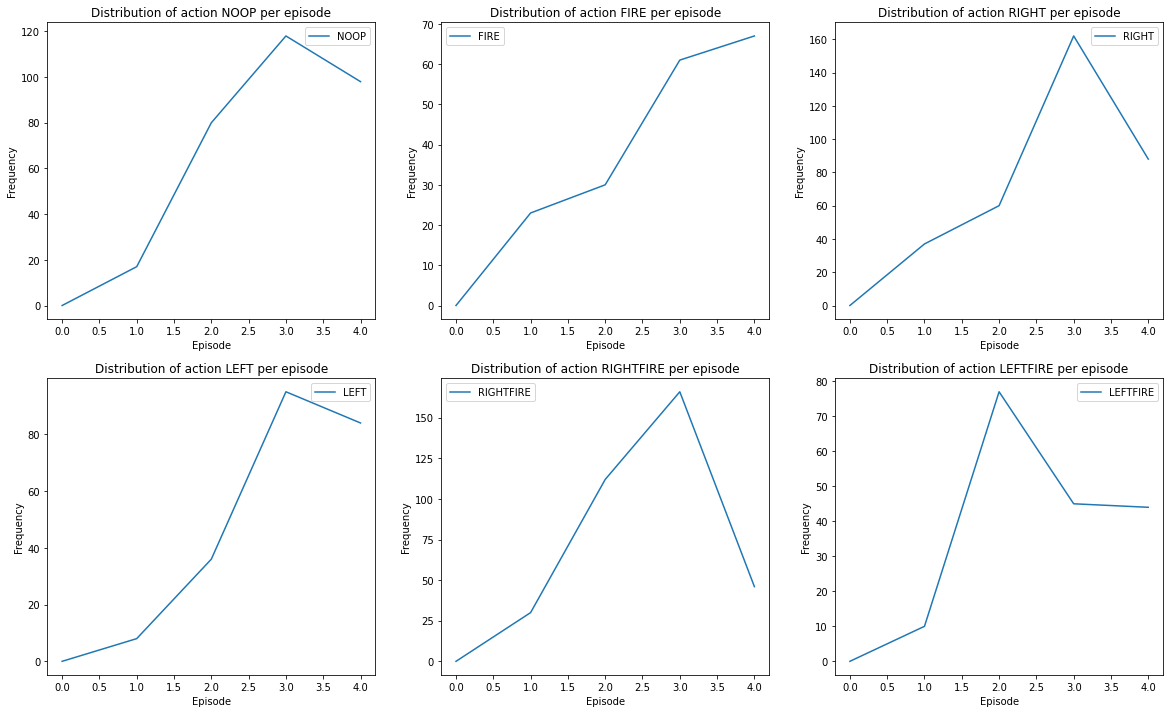

In [16]:
# Get the name of each action
action_names = env.unwrapped.get_action_meanings()

# Plot a subplot for each action distribution
fig=plt.figure(figsize=(20, 12))
for i in range(env.action_space.n):
  plt.subplot(2, 3, i+1)
  plt.plot(range(N_EPISODES), action_distribution[i], label=action_names[i])
  plt.legend()
  plt.title('Distribution of action {} per episode'.format(action_names[i])) 
  plt.xlabel('Episode')
  plt.ylabel('Frequency')
plt.show()

# Save file
fig.savefig(path+'actions_per_episode_' + version_name + '.png')

We plot the score per episode and save both the plots and the array with the data. This plot will be used to observe if the learning of the agent. If the score per episode is increasing, the agent is learning.

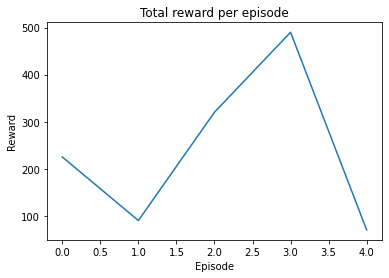

In [17]:
  # Plot
  plt.title('Total reward per episode') 
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.plot(range(N_EPISODES), reward_per_episode)

  # Save files
  plt.savefig(path + 'reward_per_episode_model_' + version_name + '.png')
  np.savetxt(path + 'reward_per_episode_' + version_name + '.csv', np.array(reward_per_episode), delimiter=",")

Finally, we save the action-value model trained by the agent so we can test it and compare with the other models in the testing notebook.

In [24]:
agent.model.save(path + 'model_' + version_name)

INFO:tensorflow:Assets written to: /contentmodel_fv_test/assets


#Analysis Starts


In [25]:
import numpy as np
import os
import sys
import random
import gym
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numpy import genfromtxt

path = os.path.abspath('')
path

'/content'

In [26]:
def compute_models_average(models_rewards):
    window_size = 100
    models_moving_avg = []
    gammas = [0.7,0.99,0.999]
    
    for rewards in models_rewards:
        i = 0
        moving_averages = []

        while i < len(rewards) - window_size + 1:

            this_window = rewards[i : i + window_size]

            window_average = np.sum(this_window) / window_size

            moving_averages.append(window_average)

            i += 1
            
        models_moving_avg.append(moving_averages)
        
    
    fig=plt.figure(figsize=(20, 12))
    for i in range(len(models_rewards)):
      plt.subplot(2,2,i+1)
      plt.plot(range(len(moving_averages)), models_moving_avg[i],label=str(gammas[i]))
      plt.legend()
      plt.title('Moving average of model with gamma value {}'.format(str(gammas[i]))) 
      plt.xlabel('Episode')
      plt.ylabel('Average reward')
    plt.show() 

In [21]:
def compute_random_agent_avg(rewards):
    window_size = 100
    
    i = 0
    moving_averages = []

    while i < len(rewards) - window_size + 1:

        this_window = rewards[i : i + window_size]

        window_average = np.sum(this_window) / window_size

        moving_averages.append(window_average)

        i += 1

    plt.plot(range(len(moving_averages)), moving_averages,label="random")
    plt.legend()
    plt.title('Moving average of model with random agent')
    plt.xlabel('Episode')
    plt.ylabel('Average reward')
    plt.show() 

In [22]:
def test_agent(env, model, iterations):
    reward_per_ep = []
    for i in tqdm(range(iterations)):
        # Initialize state and variables
        observation = env.reset()
        done = False
        
        total_ep_reward = 0

        while not done:

            if model is not None:
                #predicting q values
                observation = observation.reshape(1, -1)/255
            
                q_list = model.predict(observation).flatten()

                # Choose the optimum policy, the one that maximizes the value
                action = np.argmax(q_list)
            else:
                action = env.action_space.sample()

            # Add step to the memory
            new_observation, reward, done, info = env.step(action)
            
            total_ep_reward += reward
            # Update state
            observation = new_observation
        
        reward_per_ep.append(total_ep_reward)
        
    env.close()
    return reward_per_ep

In [34]:
%cd /content/drive/My Drive/Lectures/Elm/model_fv_test/assets

/content/drive/My Drive/Lectures/Elm/model_fv_test/assets


In [38]:
rewards_episode_gamma_07 = genfromtxt('reward_per_episode_gamma_0_7.csv', delimiter=',')
rewards_episode_gamma_099 = genfromtxt('reward_per_episode_gamma_0_99.csv', delimiter=',')
rewards_episode_gamma_0999 = genfromtxt('reward_per_episode_gamma_0_999.csv', delimiter=',')
models_rewards = [rewards_episode_gamma_07, rewards_episode_gamma_099, rewards_episode_gamma_0999]

In [39]:
env = gym.make('SpaceInvaders-ram-v0', frameskip=3)
random_agent_rewards = test_agent(env, None, 600)

  0%|          | 0/600 [00:00<?, ?it/s]

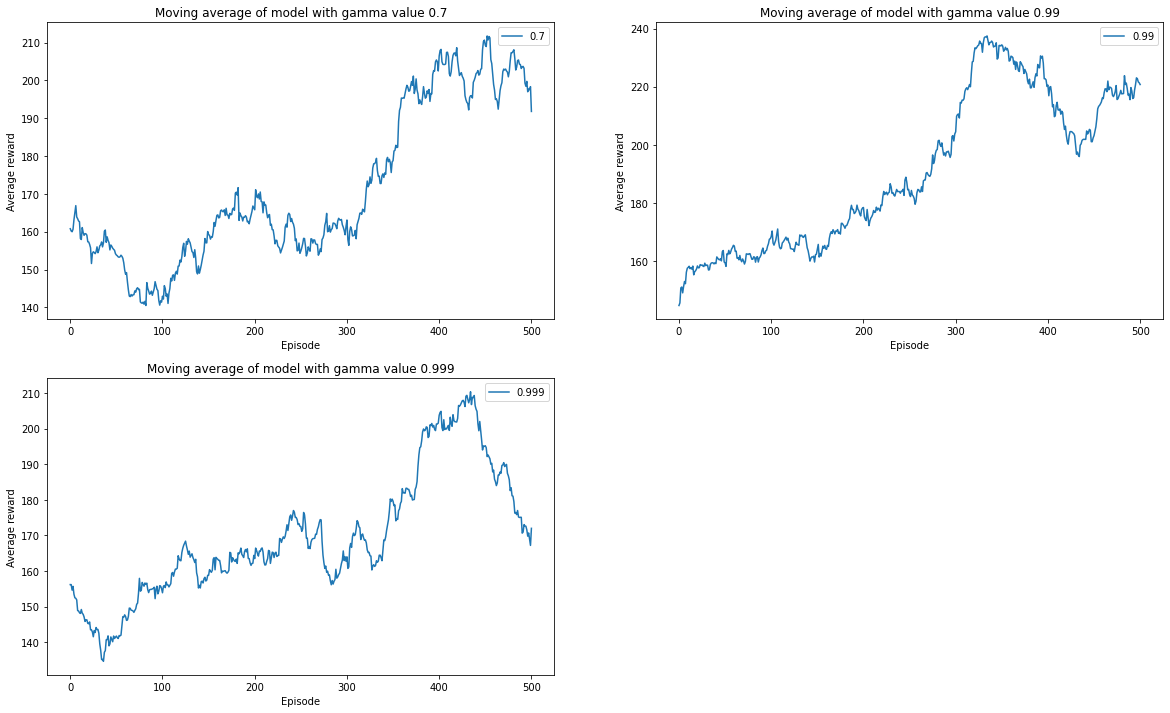

In [40]:
compute_models_average(models_rewards)

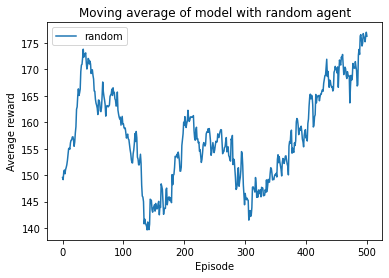

In [41]:
compute_random_agent_avg(random_agent_rewards)

In [45]:
%ls

gamma_07/                         reward_per_episode_gamma_0_999.csv
reward_per_episode_gamma_0_7.csv  reward_per_episode_gamma_0_99.csv


In [48]:
model_07 = load_model('/content/drive/MyDrive/Lectures/Elm/model_fv_test')
model_099 = load_model('/content/drive/MyDrive/Lectures/Elm/model_fv_test')
model_0999 = load_model('/content/drive/MyDrive/Lectures/Elm/model_fv_test')

In [49]:
model_07_test_rewards=test_agent(env, model_07, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [50]:
print("Average reward: ",np.mean(model_07_test_rewards), 
      "\n Maximum reward: ", np.max(model_07_test_rewards),
      "\n Minimum reward: ", np.min(model_07_test_rewards))

Average reward:  162.0 
 Maximum reward:  420.0 
 Minimum reward:  5.0


In [ ]:
model_099_test_rewards=test_agent(env, model_099, 5)

In [ ]:
print("Average reward: ",np.mean(model_099_test_rewards), 
      "\n Maximum reward: ", np.max(model_099_test_rewards),
      "\n Minimum reward: ", np.min(model_099_test_rewards))

In [ ]:
model_0999_test_rewards=test_agent(env, model_0999, 5)

In [ ]:
print("Average reward: ",np.mean(model_0999_test_rewards), 
      "\n Maximum reward: ", np.max(model_0999_test_rewards),
      "\n Minimum reward: ", np.min(model_0999_test_rewards))